In [63]:
# default_exp load

# Load

> API details.

In [64]:
#hide
from nbdev.showdoc import *

In [65]:
# %load common.py
# export

import pandas
import os
import numpy
import seaborn
import logging

In [66]:
# export
import fcsparser

In [67]:
logging.basicConfig(level=logging.INFO)

## Load EhV IDEAS exports

In [68]:
# export

def load_raw_ideas(tree_path, load_labels=False):
    
    data = []
    columns = set()
    
    for timepoint_path in os.listdir(tree_path):
        for replicate_path in os.listdir(os.path.join(tree_path, timepoint_path)):
            path = os.path.join(tree_path, timepoint_path, replicate_path)
            
            if not os.path.isfile(os.path.join(path, "focused.fcs")):
                continue
                
            logging.info(f"Loading dir {path}")
            
            meta, features = fcsparser.parse(os.path.join(path, "focused.fcs"))
            features = features.set_index("Object Number")
            features.index = features.index.astype(numpy.uint64)
            features["timepoint"] = timepoint_path
            features["replicate"] = replicate_path
            
            if load_labels:
                features["label"] = "unknown"
                for file in [p for p in os.listdir(path) if p.endswith(".txt")]:
                    label = os.path.splitext(file)[0]
                    object_numbers = pandas.read_csv(os.path.join(path, file), skiprows=1, delimiter="\t", index_col=0).index
                    features.loc[object_numbers, "label"] = label
                    
            logging.debug(f"Loaded dataframe with shape {features.shape}")
            
            if len(columns) == 0:
                columns |= set(features.columns.values.tolist())
            else:
                columns &= set(features.columns.values.tolist())
                    
            data.append(features)
            
    return pandas.concat(data)[columns]

In [69]:
df_201 = load_raw_ideas("D:/Experiment_data/weizmann/EhV/201", load_labels=True)
df_control = load_raw_ideas("D:/Experiment_data/weizmann/EhV/control", load_labels=False)

INFO:root:Loading dir D:/Experiment_data/weizmann/EhV/201\T0\R1
INFO:root:Loading dir D:/Experiment_data/weizmann/EhV/201\T0\R2
INFO:root:Loading dir D:/Experiment_data/weizmann/EhV/201\T0\R3
INFO:root:Loading dir D:/Experiment_data/weizmann/EhV/201\T4\R1
INFO:root:Loading dir D:/Experiment_data/weizmann/EhV/201\T4\R2
INFO:root:Loading dir D:/Experiment_data/weizmann/EhV/201\T4\R3
INFO:root:Loading dir D:/Experiment_data/weizmann/EhV/201\T5\R1
INFO:root:Loading dir D:/Experiment_data/weizmann/EhV/201\T5\R2
INFO:root:Loading dir D:/Experiment_data/weizmann/EhV/201\T5\R3
INFO:root:Loading dir D:/Experiment_data/weizmann/EhV/201\T6\R1
INFO:root:Loading dir D:/Experiment_data/weizmann/EhV/201\T6\R2
INFO:root:Loading dir D:/Experiment_data/weizmann/EhV/201\T6\R3
INFO:root:Loading dir D:/Experiment_data/weizmann/EhV/201\T7\R1
INFO:root:Loading dir D:/Experiment_data/weizmann/EhV/201\T7\R2
INFO:root:Loading dir D:/Experiment_data/weizmann/EhV/201\T7\R3
INFO:root:Loading dir D:/Experiment_data

## Unwanted features

### Raw features
Contain values that are not corrected for camera background intensity.

In [70]:
# export
def remove_unwanted_features(df):
    todrop = df.filter(regex="(?i).*(raw|bkgd).*").columns
       
    return df.drop(columns=todrop)

In [71]:
df_201 = remove_unwanted_features(df_201)
df_control = remove_unwanted_features(df_control)

# Stats

In [73]:
df_201.shape

(88514, 137)

In [74]:
df_control.shape

(63376, 136)

## Number of cells in controls per replicate and timepoint

<AxesSubplot:xlabel='replicate', ylabel='count'>

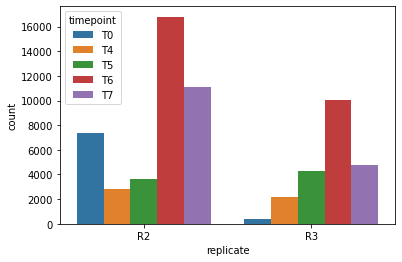

In [60]:
seaborn.countplot(x="replicate", hue="timepoint", data=df_control)

## MCP/PSBA labels per replicate and timepoint

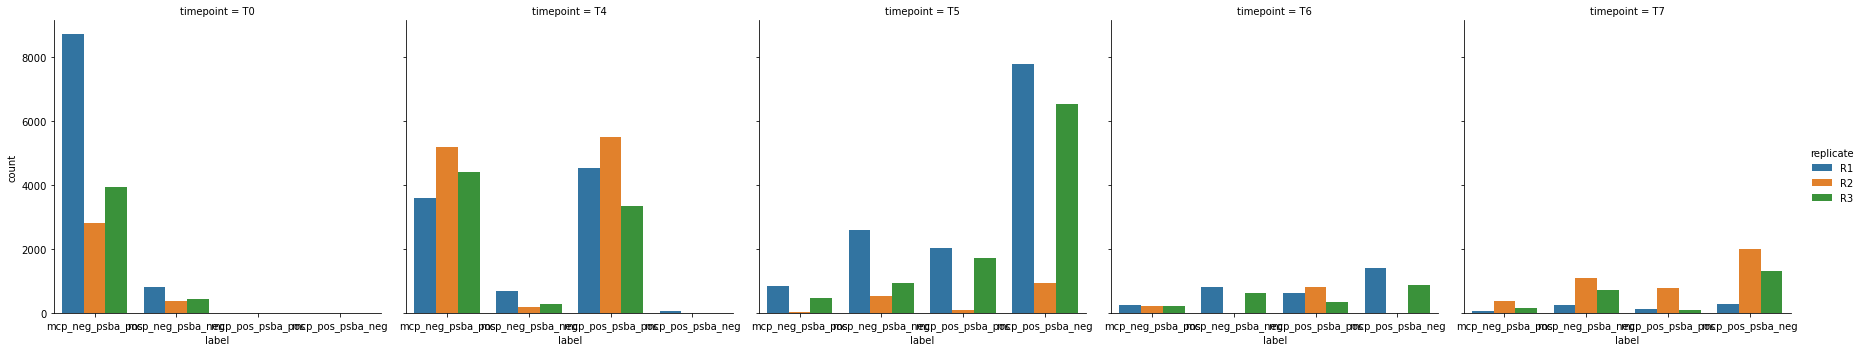

In [61]:
seaborn.catplot(x="label", hue="replicate", col="timepoint", data=df_201[df_201["label"] != "unknown"], kind="count")